In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
import seaborn as sns
import matplotlib.pyplot as plt

# Data Spliting

## 1. Training Set

In [2]:
train_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="categorical",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="training",
    validation_split=0.1,
    batch_size=32
)

Found 32000 files belonging to 2 classes.
Using 28800 files for training.


## 2. Validation Set

In [3]:
val_set = image_dataset_from_directory(
    "dataset/train",
    labels="inferred",
    label_mode="categorical",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=True,
    seed=1,
    subset="validation",
    validation_split=0.1,
    batch_size=32
)

Found 32000 files belonging to 2 classes.
Using 3200 files for validation.


## Testing Set

In [4]:
test_set = image_dataset_from_directory(
    "dataset/test",
    labels="inferred",
    label_mode="categorical",
    class_names=["Negative", "Positive"],
    image_size=(64, 64),
    shuffle=False,
    batch_size=32
)

Found 8000 files belonging to 2 classes.


### Kelas yang digunakan

In [5]:
classes = train_set.class_names

classes

['Negative', 'Positive']

In [6]:
for images, labels in train_set.take(9):
#     print(image.numpy())
    print(labels[1].numpy())
    break

[0. 1.]


### Shape Gambar

In [7]:
for images, labels in train_set.take(1):
    print(images.shape)
    print(labels.shape)
    break

(32, 64, 64, 3)
(32, 2)


## Preview Gambar

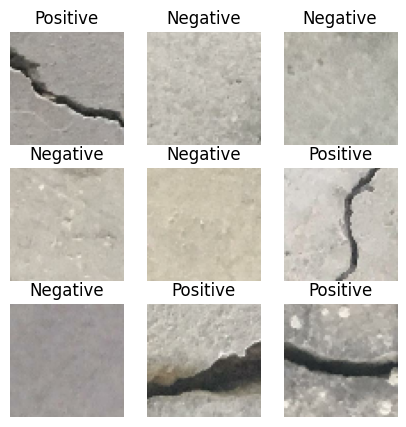

In [8]:
import matplotlib.pyplot as plt

def preview_imgs(dataset):
    plt.figure(figsize=(5, 5))

    # ambil batch 1
    for images, labels in dataset.take(1):
        
        # ambil 9 gambar
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))

            plt.title("Negative") if labels[i].numpy()[0] == 1 else plt.title("Positive")

            plt.axis("off")

            
preview_imgs(train_set)

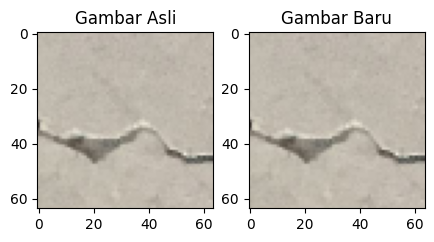

In [9]:
def sample_img(image1, image2):
    plt.figure(figsize=(5, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Gambar Asli")
    plt.imshow(image1.numpy().astype("uint8"))
    
    plt.subplot(1, 2, 2)
    plt.title("Gambar Baru")
    plt.imshow(image2.numpy().astype("uint8"))

# ambil 1 contoh gambar
for images, labels in train_set.take(1):
    ori_img = images[0]

sample_img(ori_img, ori_img)

# Preprocessing Images

## 1. Brightness
Sesuaikan kecerahan gambar

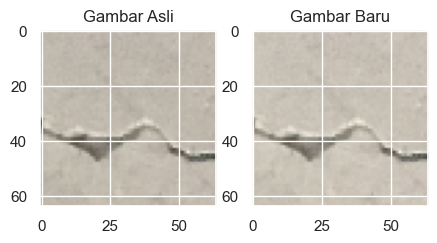

In [27]:
sample_img(ori_img, tf.image.random_brightness(ori_img, max_delta=10, seed=42))

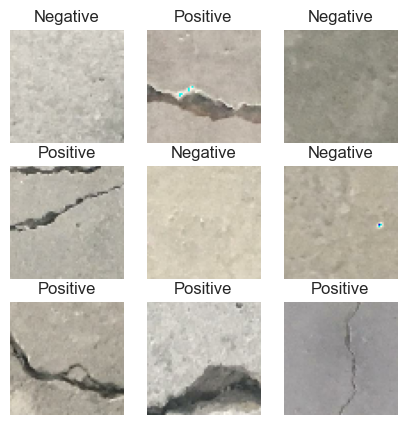

In [26]:
def brightness(x, y):
    image = tf.image.random_brightness(x, max_delta=10, seed=42)
    return image, y

b_train = train_set.map(brightness)
b_val = val_set.map(brightness)
b_test = test_set.map(brightness)

preview_imgs(b_train)

## 2. Hue
Memberikan nuansa warna baru pada gambar

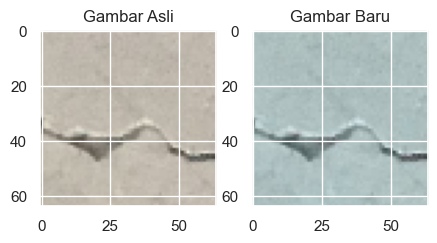

In [28]:
sample_img(ori_img, tf.image.random_hue(ori_img, max_delta=0.5, seed=42))

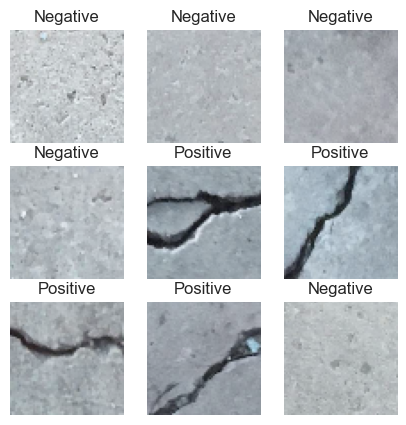

In [25]:
def hue(x, y):
    image = tf.image.random_hue(x, max_delta=0.5, seed=42)
    return image, y
    
hue_train = b_train.map(hue)
hue_val = b_val.map(hue)
hue_test = b_test.map(hue)

preview_imgs(hue_train)

## 3. Saturation
Menyesuaikan insensitas warna. Semakin tinggi saturasi, semakin terang

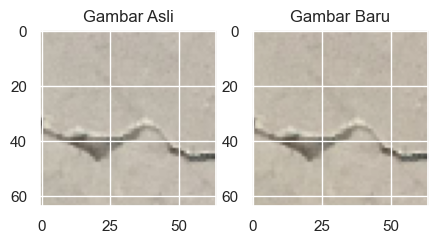

In [29]:
sample_img(ori_img, tf.image.random_saturation(ori_img, 0.5, 1.5, seed=42))

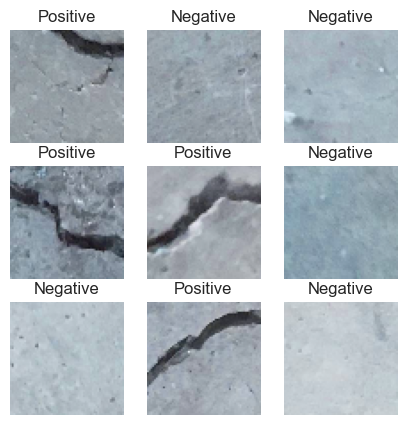

In [31]:
def saturate(x, y):
    image = tf.image.random_saturation(x, 0.5, 1.5, seed=42)
    return image, y
    
s_train = hue_train.map(saturate)
s_val = hue_val.map(saturate)
s_test = hue_test.map(saturate)

preview_imgs(s_train)

## 5. Grayscale
Membuat gambar skala abu-abu

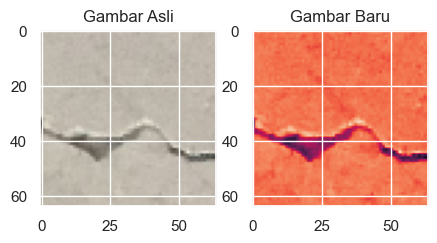

In [50]:
sample_img(ori_img, tf.image.rgb_to_grayscale(ori_img))

#### Grayscale Seluruh Gambar

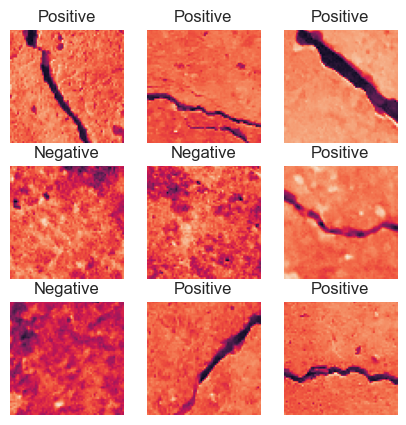

In [51]:
def grayscale(x, y):
    image = tf.image.rgb_to_grayscale(x)
    return image, y

g_train = train_set.map(grayscale)
g_val = train_set.map(grayscale)
g_test = train_set.map(grayscale)

preview_imgs(g_train)

In [52]:
for image, label in g_train.take(1):
    print(image.numpy().shape)
    break

(32, 64, 64, 1)


## 6. Contrast
Meningkatkan perbedaan antara bagian yang lebih cerah dan lebih gelap

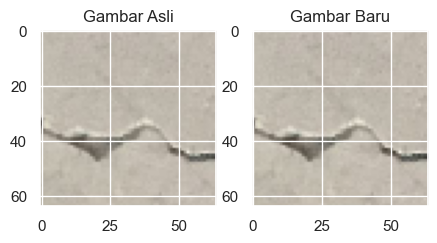

In [34]:
sample_img(ori_img, tf.image.random_contrast(ori_img, 1, 1.5, seed=42))

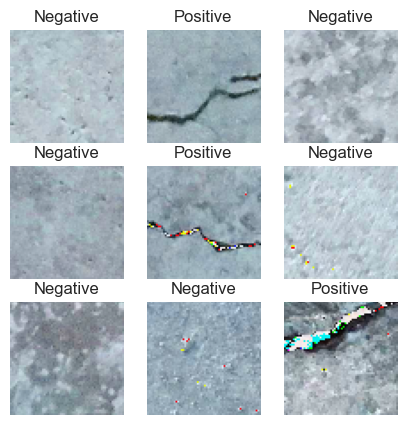

In [35]:
def contrast(x, y):
    image = tf.image.random_contrast(x, 1, 1.5, seed=42)
    return image, y

c_train_rgb = s_train.map(contrast)
c_val_rgb = s_val.map(contrast)
c_test_rgb = s_test.map(contrast)

preview_imgs(c_train_rgb)

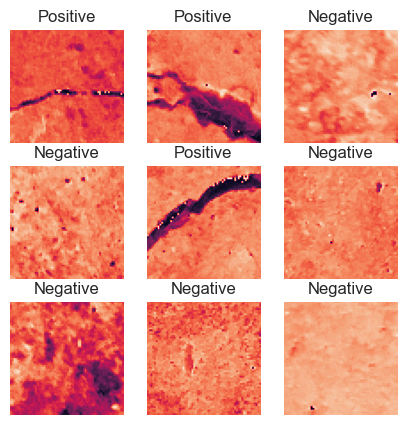

In [53]:
c_train_gray = g_train.map(contrast)
c_val_gray = g_val.map(contrast)
c_test_gray = g_test.map(contrast)

preview_imgs(c_train_gray)

## 4. Standardisasi
Standardisasi gambar sehingga memiliki rata-rata 0 dan varians 1

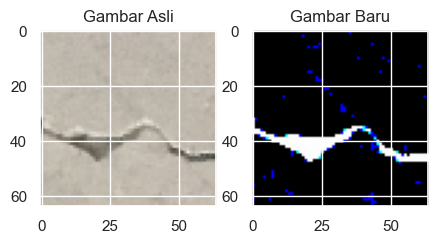

In [55]:
sample_img(ori_img, tf.image.per_image_standardization(ori_img))

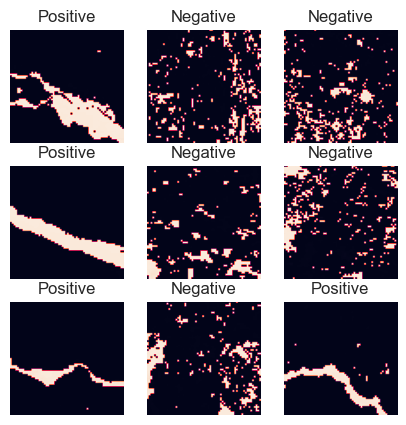

In [54]:
def standardization(x, y):
    image = tf.image.per_image_standardization(x)
    return image, y

std_train_gray = g_train.map(standardization)
std_val_gray = g_val.map(standardization)
std_test_gray = g_test.map(standardization)

preview_imgs(std_train_gray)

# Modelling

## 1. Model RGB

In [10]:
model_rgb = Sequential([
    Input((64, 64, 3)),
    
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(64, activation="relu"),
    Dense(2, activation="sigmoid")
])

model_rgb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [11]:
model_rgb.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model RGB - Gambar Asli - Fitting Model

In [13]:
history = model_rgb.fit(
    train_set,
    validation_data = val_set,
    epochs=10,
    verbose=1
)

Epoch 1/10
900/900 [==============================] - 85s 93ms/step - loss: 0.2819 - accuracy: 0.9593 - val_loss: 0.0646 - val_accuracy: 0.9822
Epoch 2/10
900/900 [==============================] - 155s 173ms/step - loss: 0.0479 - accuracy: 0.9856 - val_loss: 0.0496 - val_accuracy: 0.9822
Epoch 3/10
900/900 [==============================] - 177s 196ms/step - loss: 0.0388 - accuracy: 0.9876 - val_loss: 0.0381 - val_accuracy: 0.9866
Epoch 4/10
900/900 [==============================] - 171s 190ms/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.0323 - val_accuracy: 0.9903
Epoch 5/10
900/900 [==============================] - 171s 190ms/step - loss: 0.0315 - accuracy: 0.9905 - val_loss: 0.0395 - val_accuracy: 0.9841
Epoch 6/10
900/900 [==============================] - 164s 183ms/step - loss: 0.0240 - accuracy: 0.9930 - val_loss: 0.0616 - val_accuracy: 0.9772
Epoch 7/10
900/900 [==============================] - 179s 199ms/step - loss: 0.0273 - accuracy: 0.9915 - val_loss: 0.0272 - v

### Model RGB - Gambar Asli - Visualisasi

In [36]:
def visualisasi_plot(model):
    epoch = [i+1 for i in range(10)]

    sns.set_theme()

    plt.figure(figsize=(16, 8))
    plt.suptitle("Train vs Validation")

    # grafik akurasi
    plt.subplot(1, 2, 1)
    plt.title("Akurasi")
    sns.lineplot(
        x=epoch,
        y=model.history["accuracy"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_accuracy"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Akurasi(%)")

    # grafik loss
    plt.subplot(1, 2, 2)
    plt.title("Loss")
    sns.lineplot(
        x=epoch,
        y=model.history["loss"],
        label="Training"
    )
    sns.lineplot(
        x=epoch,
        y=model.history["val_loss"],
        label="Validation"
    )
    plt.xticks(epoch)
    plt.xlabel("Epoch")
    plt.ylabel("Loss(%)")

    plt.show()

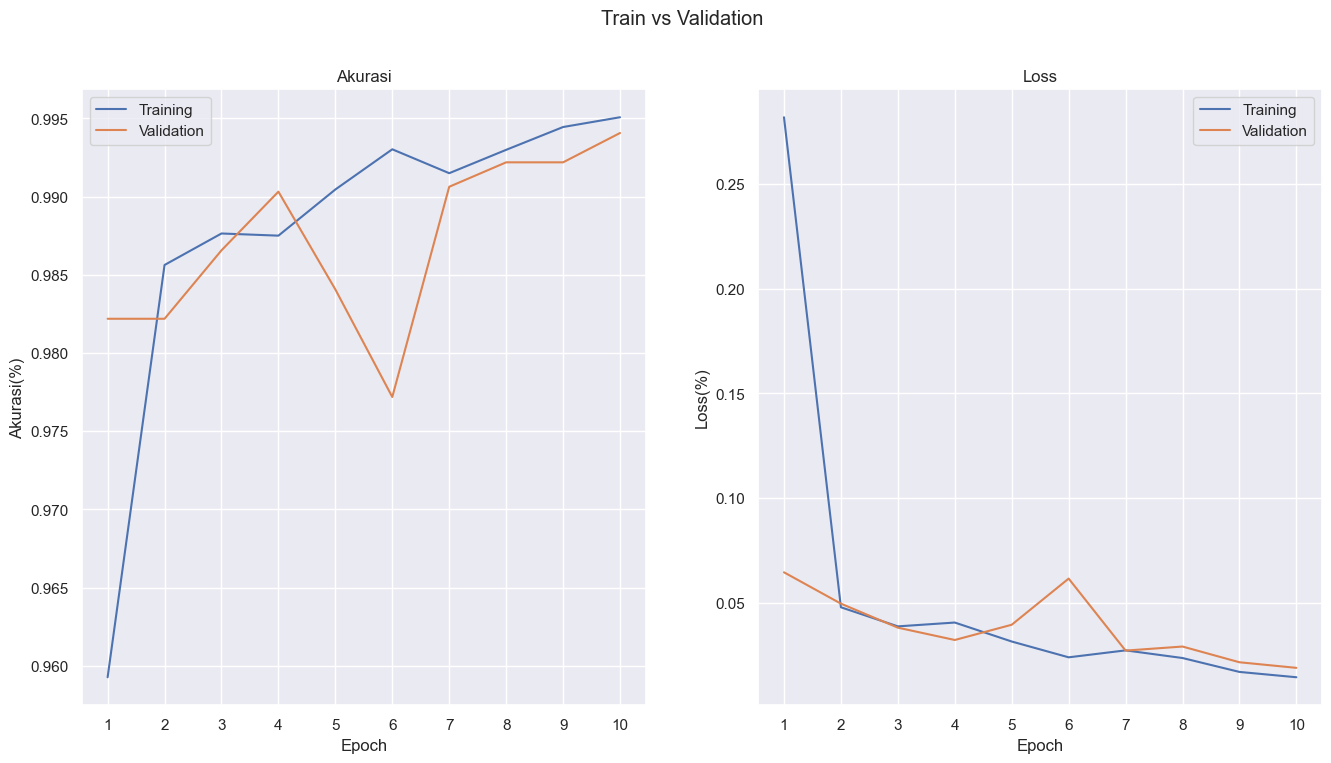

In [37]:
visualisasi_plot(history)

In [45]:
score = model_rgb.evaluate(
    test_set,
    verbose=1
)

print(f"TEST LOSS\t: {score[0]}\
      \nTEST ACCURACY\t: {score[1]*100}%")

250/250 [==============================] - 7s 27ms/step - loss: 0.0290 - accuracy: 0.9911
TEST LOSS	: 0.029017021879553795      
TEST ACCURACY	: 99.11249876022339%


### Model RGB - Gambar Preprocessing - Fitting Model

In [38]:
history2 = model_rgb.fit(
    c_train_rgb,
    validation_data = c_val_rgb,
    epochs=10,
    verbose=1
)

Epoch 1/10
900/900 [==============================] - 78s 87ms/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.0267 - val_accuracy: 0.9937
Epoch 2/10
900/900 [==============================] - 107s 118ms/step - loss: 0.0163 - accuracy: 0.9958 - val_loss: 0.0199 - val_accuracy: 0.9959
Epoch 3/10
900/900 [==============================] - 163s 181ms/step - loss: 0.0122 - accuracy: 0.9966 - val_loss: 0.0963 - val_accuracy: 0.9869
Epoch 4/10
900/900 [==============================] - 165s 183ms/step - loss: 0.0354 - accuracy: 0.9921 - val_loss: 0.0261 - val_accuracy: 0.9956
Epoch 5/10
900/900 [==============================] - 163s 181ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.0163 - val_accuracy: 0.9953
Epoch 6/10
900/900 [==============================] - 161s 178ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0255 - val_accuracy: 0.9944
Epoch 7/10
900/900 [==============================] - 160s 178ms/step - loss: 0.0132 - accuracy: 0.9969 - val_loss: 0.0186 - v

### Model RGB - Gambar Preprocessing - Visualisasi

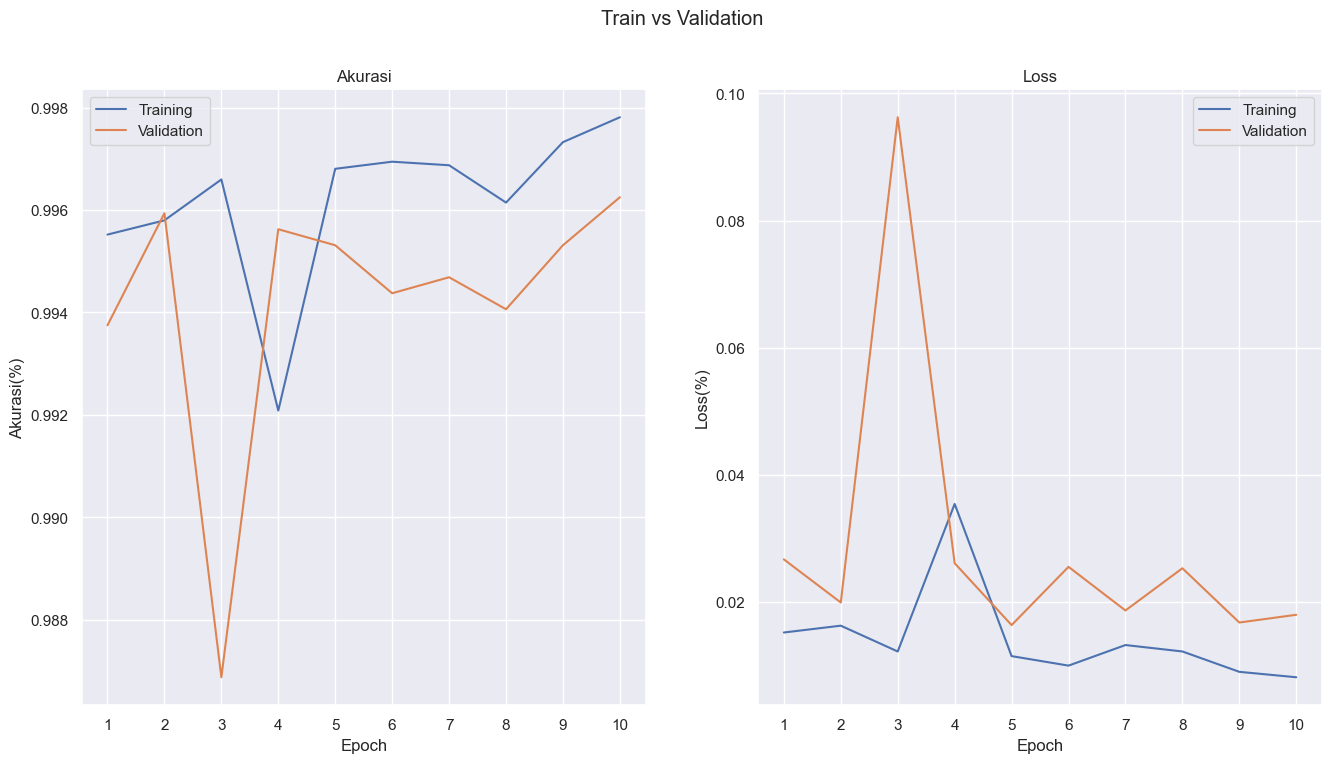

In [39]:
visualisasi_plot(history2)

### Model RGB - Gambar Preprocessing - Evaluasi

In [46]:
score = model_rgb.evaluate(
    c_test_rgb,
    verbose=1
)

print(f"TEST LOSS\t: {score[0]}\
      \nTEST ACCURACY\t: {score[1]*100}%")

250/250 [==============================] - 7s 29ms/step - loss: 0.0119 - accuracy: 0.9980
TEST LOSS	: 0.011866719461977482      
TEST ACCURACY	: 99.80000257492065%


## 2. Model Grayscale

In [58]:
model_gray = Sequential([
    Input((64, 64, 1)),
    
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(),
    
    Flatten(),
    Dense(64, activation="relu"),
    Dense(2, activation="sigmoid")
])

model_rgb.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)       

In [59]:
model_gray.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model Grayscale - Gambar Preprocessing - Fitting Model

In [60]:
history3 = model_gray.fit(
    c_train_gray,
    validation_data = c_val_gray,
    epochs=10,
    verbose=1
)

Epoch 1/10
900/900 [==============================] - 121s 134ms/step - loss: 0.2062 - accuracy: 0.9695 - val_loss: 0.0431 - val_accuracy: 0.9865
Epoch 2/10
900/900 [==============================] - 191s 213ms/step - loss: 0.0500 - accuracy: 0.9855 - val_loss: 0.0457 - val_accuracy: 0.9879
Epoch 3/10
900/900 [==============================] - 178s 198ms/step - loss: 0.0359 - accuracy: 0.9898 - val_loss: 0.0150 - val_accuracy: 0.9958
Epoch 4/10
900/900 [==============================] - 157s 174ms/step - loss: 0.0578 - accuracy: 0.9836 - val_loss: 0.0263 - val_accuracy: 0.9915
Epoch 5/10
900/900 [==============================] - 222s 247ms/step - loss: 0.0249 - accuracy: 0.9926 - val_loss: 0.0195 - val_accuracy: 0.9941
Epoch 6/10
900/900 [==============================] - 198s 220ms/step - loss: 0.0168 - accuracy: 0.9948 - val_loss: 0.0111 - val_accuracy: 0.9968
Epoch 7/10
900/900 [==============================] - 193s 214ms/step - loss: 0.0154 - accuracy: 0.9955 - val_loss: 0.0321 -

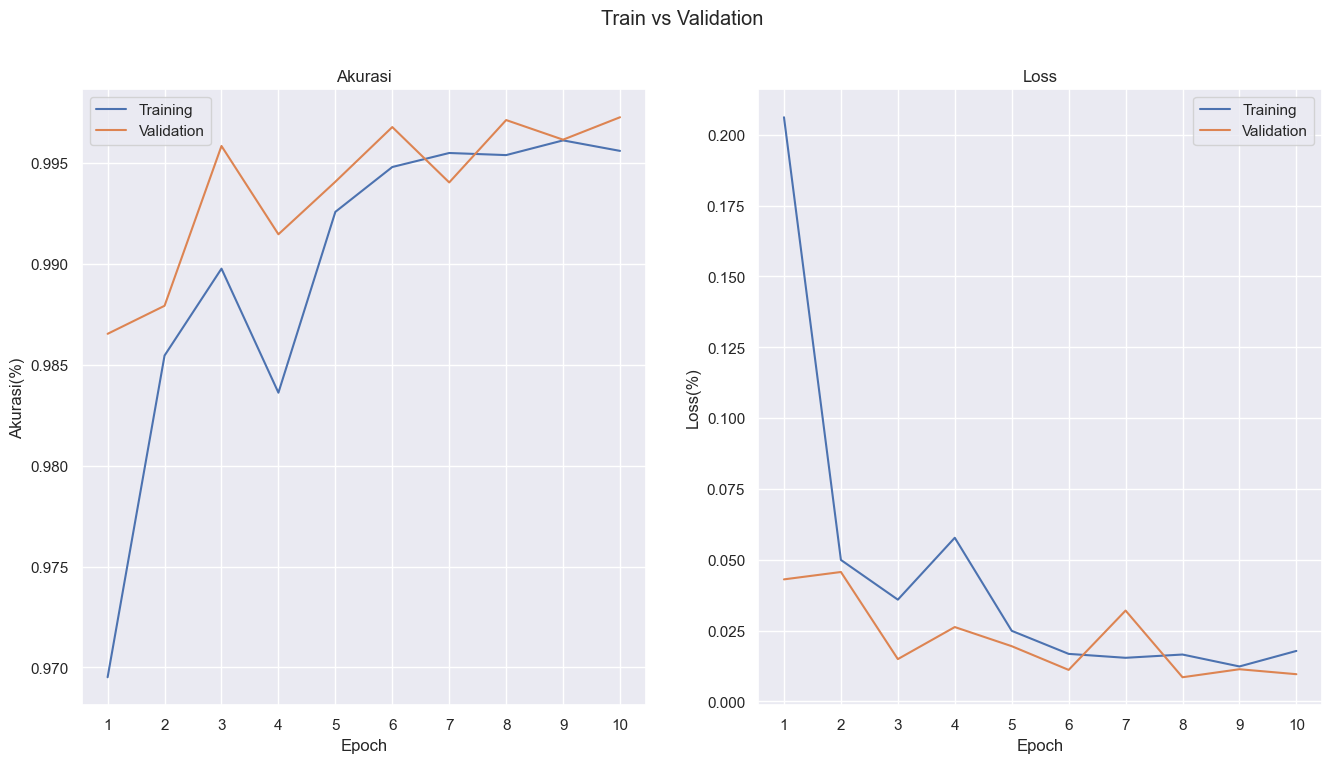

In [61]:
visualisasi_plot(history3)

In [62]:
score = model_gray.evaluate(
    c_test_gray,
    verbose=1
)

print(f"TEST LOSS\t: {score[0]}\
      \nTEST ACCURACY\t: {score[1]*100}%")

900/900 [==============================] - 58s 64ms/step - loss: 0.0100 - accuracy: 0.9980
TEST LOSS	: 0.01001649722456932      
TEST ACCURACY	: 99.79513883590698%


900/900 [==============================] - 57s 63ms/step


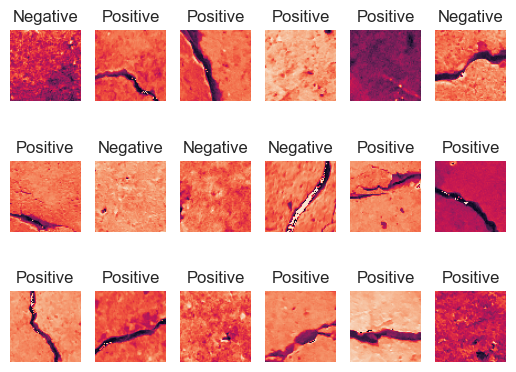

In [64]:
y_pred = model_gray.predict(c_test_gray)

for images, labels in c_test_gray.take(1):
    for i in range(18):
        plt.subplot(3, 6, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Negative") if y_pred[i][0] == 0 else plt.title("Positive")
        plt.axis("off")